In [1]:
import re
from datetime import datetime
from pathlib import Path
from typing import Any

import numpy as np
import polars as pl
import xarray as xr

gnd_path = Path.cwd() / "output/C1gnd.out"

with gnd_path.open("r") as f:
    lines = f.readlines()


In [2]:
def parse_geometry_line(line: str) -> dict[str, Any] | None:
    """
    Parse a single line from the geometry section.

    Args:
        line (str): Line containing atom geometry data

    Returns
    -------
        dict or None: Dictionary with atom information or None if parsing failed
    """
    # Don't try to parse header or separator lines
    if "----" in line or ("Atom" in line and "x" in line):
        return None

    # Simple but robust pattern matching - split by whitespace
    parts = line.strip().split()

    # Check if we have enough parts to make a valid atom entry
    if len(parts) >= 8:  # At least 8 elements for a geometry line
        try:
            # Extract the index and atom name considering the format "1) C01"
            idx_str = parts[0]
            atom_str = parts[1]

            # If the first part has a trailing ")", it contains the index
            if idx_str.endswith(")"):
                _ = idx_str.rstrip(")")
            else:
                # Handle case where index and atom are merged like "1)C01"
                match = re.match(r"(\d+)\)(.*)", idx_str)
                if match:
                    atom_str = match.group(2)

            return {
                "atom": atom_str,
                "x": float(parts[2]) if len(parts) > 2 else 0.0,
                "y": float(parts[3]) if len(parts) > 3 else 0.0,
                "z": float(parts[4]) if len(parts) > 4 else 0.0,
                "q": float(parts[5]) if len(parts) > 5 else 0.0,
                "nuc": int(parts[6]) if len(parts) > 6 else 0,
                "mass": float(parts[7]) if len(parts) > 7 else 0.0,
                "neq": parts[8] if len(parts) > 8 else "",
                "grid": int(parts[9]) if len(parts) > 9 else 0,
                "grp": int(parts[10]) if len(parts) > 10 else 0,
            }
        except (ValueError, IndexError):
            # Log diagnostic info if needed
            # print(f"Failed to parse line: {line}")
            return None

    return None


def extract_section(
    content: list[str], start_pattern: str, end_pattern: str
) -> list[str]:
    """
    Extract a section from the file content between start and end patterns.

    Args:
        content (list): List of lines from the file
        start_pattern (str): Regex pattern to match the start of the section
        end_pattern (str): Regex pattern to match the end of the section

    Returns
    -------
        list: Lines of the extracted section
    """
    section = []
    in_section = False
    for line in content:
        # Check if we're at the start of the section
        if not in_section and re.search(start_pattern, line):
            in_section = True
            section.append(line)
        # If we're already in the section
        elif in_section:
            section.append(line)
            # Check if we've reached the end of the section
            if re.search(end_pattern, line):
                break

    return section

In [3]:
def extract_geometry(lines: list[str]) -> pl.DataFrame:
    """
    Extract the geometry section from the GND file.
    """
    geometry_section = extract_section(
        lines,
        start_pattern=r"INPUT GEOMETRY \(input file\)",
        end_pattern=r"Smallest atom distance.*?=.*?\d+\.\d+",
    )
    geometry = pl.DataFrame(
        [
            parse_geometry_line(line)
            for line in geometry_section
            if line.strip() and parse_geometry_line(line) is not None
        ]
    )
    return geometry


geometry = extract_geometry(lines)
geometry

atom,x,y,z,q,nuc,mass,neq,grid,grp
str,f64,f64,f64,f64,i64,f64,str,i64,i64
"""C01""",1.096564,-2.795541,-0.126884,6.0,6,12.011,"""1/""",1,32
"""C02""",0.650113,-4.188295,-0.15538,4.0,6,12.011,"""2/""",1,32
"""C03""",1.330451,-5.393227,-0.302897,4.0,6,12.011,"""3/""",1,32
"""C04""",0.576055,-6.558919,-0.305203,4.0,6,12.011,"""4/""",1,32
"""C05""",-0.812707,-6.525957,-0.159831,4.0,6,12.011,"""5/""",1,32
…,…,…,…,…,…,…,…,…,…
"""N05""",-2.37713,2.429006,0.208542,7.0,7,14.007,"""53/""",1,32
"""N06""",0.0,1.982701,0.0,7.0,7,14.007,"""54/""",1,32
"""N07""",2.38824,2.356362,-0.214891,7.0,7,14.007,"""55/""",1,32


In [4]:
# pass geometry into an xarray dataset

geometry_ds = xr.Dataset(
    {
        "x": (("atom"), geometry["x"].to_numpy()),
        "y": (("atom"), geometry["y"].to_numpy()),
        "z": (("atom"), geometry["z"].to_numpy()),
        "q": (("atom"), geometry["q"].to_numpy()),
        "nuc": (("atom"), geometry["nuc"].to_numpy()),
        "mass": (("atom"), geometry["mass"].to_numpy()),
        "neq": (("atom"), geometry["neq"].to_numpy()),
        "grid": (("atom"), geometry["grid"].to_numpy()),
        "grp": (("atom"), geometry["grp"].to_numpy()),
    },
    coords={
        "atom": geometry["atom"].to_numpy(),
    },
)
geometry_ds.to_netcdf(
    Path.cwd() / "output/geometry.nc",
    mode="w",
    engine="h5netcdf",
)
geometry_ds

<xarray.Dataset> Size: 5kB
Dimensions:  (atom: 57)
Coordinates:
  * atom     (atom) object 456B 'C01' 'C02' 'C03' 'C04' ... 'N07' 'N08' 'Zn01'
Data variables:
    x        (atom) float64 456B 1.097 0.6501 1.33 0.5761 ... 2.388 1.973 0.0
    y        (atom) float64 456B -2.796 -4.188 -5.393 ... 2.356 -0.03092 0.0
    z        (atom) float64 456B -0.1269 -0.1554 -0.3029 ... -0.2149 -0.1647 0.0
    q        (atom) float64 456B 6.0 4.0 4.0 4.0 4.0 ... 7.0 7.0 7.0 7.0 30.0
    nuc      (atom) int64 456B 6 6 6 6 6 6 6 6 6 6 6 ... 1 1 7 7 7 7 7 7 7 7 30
    mass     (atom) float64 456B 12.01 12.01 12.01 12.01 ... 14.01 14.01 65.37
    neq      (atom) object 456B '1/' '2/' '3/' '4/' ... '54/' '55/' '56/' '57/'
    grid     (atom) int64 456B 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    grp      (atom) int64 456B 32 32 32 32 32 32 32 32 ... 32 32 32 32 32 32 32

In [5]:
def extract_basis_set(line):
    """
    Extract the basis set information from a line.

    Parameters
    ----------
    line : str
        A line from the basis set section of the GND file.

    Returns
    -------
    dict or None
        A dictionary with the basis set information or None if parsing failed.
    """
    # ensure the line is not the header or separator line
    if "I" in line or "II" in line or "III" in line:
        return None
    # parse the line by atom, and basis set
    parts = line.split()
    if len(parts) < 2:
        return None
    return {
        "atom": parts[1],
        "basis": " ".join(parts[3:]),
    }


def extract_basis_sets(lines: list[str]) -> pl.DataFrame:
    """
    Extract the basis sets from the GND file.

    Parameters
    ----------
    lines : list[str]
        The lines from the GND file.

    Returns
    -------
    pl.DataFrame
        A DataFrame containing the basis set information.
    """
    # Extract different basis set sections
    section_configs = [
        {
            "name": "aux",
            "start": r"I\)  AUXILIARY BASIS SETS",
            "end": r"II\)  ORBITAL BASIS SETS",
            "suffix": "",
        },
        {
            "name": "orbital",
            "start": r"II\)  ORBITAL BASIS SETS",
            "end": r" BASIS DIMENSIONS",
            "suffix": "_orbital",
        },
        {
            "name": "model_core",
            "start": r"III\)  MODEL POTENTIALS",
            "end": r" \(NEW\) SYMMETRIZATION INFORMATION",
            "suffix": "_model_core",
        },
    ]

    # Extract and process each section
    dfs = {}
    for config in section_configs:
        section = extract_section(
            lines,
            start_pattern=config["start"],
            end_pattern=config["end"],
        )

        # Filter and parse data
        data = [
            entry
            for line in section
            if line.strip() and (entry := extract_basis_set(line)) is not None
        ]

        # Create DataFrame or empty placeholder
        dfs[config["name"]] = (
            pl.DataFrame(data) if data else pl.DataFrame({"atom": [], "basis": []})
        )

    # Combine DataFrames using left joins to preserve all rows from orbital basis
    basis_sets = (
        dfs["orbital"]
        .join(dfs["aux"], on="atom", how="left", suffix=" auxiliary")
        .join(
            dfs["model_core"],
            on="atom",
            how="left",
            suffix=" model core potential",
        )
    )

    return basis_sets


basis = extract_basis_sets(lines)

basis_ds = xr.Dataset(
    {
        "orbital_basis": (("atom"), basis["basis"].to_numpy()),
        "auxiliary_basis": (("atom"), basis["basis auxiliary"].to_numpy()),
        "model_core_basis": (
            ("atom"),
            basis["basis model core potential"].to_numpy(),
        ),
    },
    coords={
        "atom": basis["atom"].to_numpy(),
    },
)
basis_ds

<xarray.Dataset> Size: 2kB
Dimensions:           (atom: 48)
Coordinates:
  * atom              (atom) object 384B 'C01' 'C02' 'C03' ... 'H14' 'H15' 'H16'
Data variables:
    orbital_basis     (atom) object 384B 'O-CARBON iii_iglo' ... 'O-HYDROGEN ...
    auxiliary_basis   (atom) object 384B 'A-CARBON (5,2;5,2)' ... 'A-HYDROGEN...
    model_core_basis  (atom) object 384B None 'P-CARBON(+4) (3,1:8,0)' ... None

In [6]:
def extract_energy(line: str) -> dict[str, Any] | None:
    """
    Extract energy information from a line.

    Args:
        line (str): Line containing energy data
        pattern (str): Regex pattern to match the energy data

    Returns
    -------
        dict or None: Dictionary with energy information or None if parsing failed
    """
    if "<Rho/" in line:
        return None
    # Energies have the pattern
    # \sKind of energy (H) = value
    pattern = r"([\w\s-]+?)\s*\((\w+)\)\s*=\s*([+-]?\d+\.\d+)"
    match = re.search(pattern, line)
    if match:
        energy_type = match.group(1).strip()  # Strip whitespace from the type
        energy_value = float(match.group(3)) * 27.2114  # convert from Hartree to eV
        return {
            "type": energy_type,
            "value": energy_value,
        }
    return None


def extract_energy_section(lines: list[str]) -> list[dict[str, Any]]:
    """
    Extract energy information from the energy section.

    Args:
        lines (list): Lines from the energy section

    Returns
    -------
        list: List of dictionaries with energy information
    """
    energy_section = extract_section(
        lines,
        start_pattern=r" FINAL ENERGY",
        end_pattern=r" Decomposition of",
    )
    return [
        entry
        for line in energy_section
        if line.strip() and (entry := extract_energy(line)) is not None
    ]


ground_energy_section = extract_energy_section(lines)
# Create a dataset with each energy type as a separate variable
ground_energy_ds = xr.Dataset(
    {
        entry["type"].replace(" ", "_").lower(): ([], entry["value"])
        for entry in ground_energy_section
    },
)
ground_energy_ds

<xarray.Dataset> Size: 64B
Dimensions:                   ()
Data variables:
    total_energy              float64 8B -6.636e+04
    nuc-nuc_energy            float64 8B 8.772e+04
    el-nuc_energy             float64 8B -3.334e+05
    kinetic_energy            float64 8B 6.595e+04
    coulomb_energy            float64 8B 1.186e+05
    ex-cor_energy             float64 8B -5.242e+03
    total_exchange_energy     float64 8B -4.996e+03
    total_correlation_energy  float64 8B -245.9

In [7]:
def extract_orbital_energies(lines: list[str]) -> pl.DataFrame:
    """
    Extract orbital energy information from the GND file.

    Parameters
    ----------
    lines : list[str]
        The lines from the GND file.

    Returns
    -------
    dict
        A dictionary containing the orbital energy information for alpha and beta spins.
    """
    orbital_section = extract_section(
        lines,
        start_pattern=r"ORBITAL ENERGIES \(ALL VIRTUALS INCLUDED\)",
        end_pattern=r" LISTING OF SPIN ALPHA ORBITALS ONLY",
    )

    # Skip header lines (2 lines for header, 1 for column names)
    data_lines = orbital_section[3:]

    # Initialize lists to store the parsed data
    orbitals = []
    alpha_occupations = []
    alpha_energies = []
    alpha_symmetries = []
    alpha_positions = []
    beta_occupations = []
    beta_energies = []
    beta_symmetries = []
    beta_positions = []

    # Parse each data line
    for line in data_lines:
        if not line.strip():  # Skip empty lines
            continue

        parts = line.split()
        if len(parts) >= 11:  # Check if we have enough parts for a complete line
            try:
                orbital_num = int(parts[0])
                orbitals.append(orbital_num)

                # Alpha spin data
                alpha_occupations.append(float(parts[1]))
                alpha_energies.append(float(parts[2]))
                alpha_symmetries.append(parts[3])
                alpha_positions.append(int(parts[5].strip("()")))

                # Beta spin data
                beta_occupations.append(float(parts[6]))
                beta_energies.append(float(parts[7]))
                beta_symmetries.append(parts[8])
                beta_positions.append(int(parts[10].strip("()")))
            except (ValueError, IndexError):
                # Skip lines that don't match the expected format
                continue

    return pl.DataFrame(
        {
            "orbital": orbitals,
            "alpha_occupation": alpha_occupations,
            "alpha_energy": alpha_energies,
            "alpha_symmetry": alpha_symmetries,
            "alpha_position": alpha_positions,
            "beta_occupation": beta_occupations,
            "beta_energy": beta_energies,
            "beta_symmetry": beta_symmetries,
            "beta_position": beta_positions,
        }
    )


gnd_spin_section = extract_orbital_energies(lines)
# get the lumo and homo orbital numbers where occupation first = 0
homo_orbital = next(
    (i for i, occ in enumerate(gnd_spin_section["alpha_occupation"]) if occ == 0), None
)
homo_energy = (
    gnd_spin_section["alpha_energy"].to_numpy()[homo_orbital]
    if homo_orbital is not None
    else None
)
lumo_orbital = homo_orbital + 1 if homo_orbital is not None else None
lumo_energy = (
    gnd_spin_section["alpha_energy"].to_numpy()[lumo_orbital]
    if lumo_orbital is not None
    else None
)

# Create a dataset with each energy type as a separate variable
gnd_spin_ds = xr.Dataset(
    {
        "homo": homo_orbital,  # Store the orbital number as a scalar
        "lumo": lumo_orbital,  # Store the orbital number as a scalar
        "homo_energy": homo_energy,  # Also store the energy value
        "lumo_energy": lumo_energy,  # Also store the energy value
        "orbital": (("orbital"), gnd_spin_section["orbital"].to_numpy()),
        "alpha_occupation": (
            ("orbital"),
            gnd_spin_section["alpha_occupation"].to_numpy(),
        ),
        "alpha_energy": (("orbital"), gnd_spin_section["alpha_energy"].to_numpy()),
        "alpha_symmetry": (
            ("orbital"),
            gnd_spin_section["alpha_symmetry"].to_numpy(),
        ),
        "alpha_position": (
            ("orbital"),
            gnd_spin_section["alpha_position"].to_numpy(),
        ),
        "beta_occupation": (
            ("orbital"),
            gnd_spin_section["beta_occupation"].to_numpy(),
        ),
        "beta_energy": (("orbital"), gnd_spin_section["beta_energy"].to_numpy()),
        "beta_symmetry": (("orbital"), gnd_spin_section["beta_symmetry"].to_numpy()),
        "beta_position": (("orbital"), gnd_spin_section["beta_position"].to_numpy()),
    },
    coords={
        "atom": geometry["atom"].to_numpy(),
    },
)
gnd_spin_ds

<xarray.Dataset> Size: 53kB
Dimensions:           (orbital: 727, atom: 57)
Coordinates:
  * orbital           (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
  * atom              (atom) object 456B 'C01' 'C02' 'C03' ... 'N08' 'Zn01'
Data variables:
    homo              int64 8B 116
    lumo              int64 8B 117
    homo_energy       float64 8B -3.399
    lumo_energy       float64 8B -3.365
    alpha_occupation  (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    alpha_energy      (orbital) float64 6kB -9.408e+03 -1.132e+03 ... 3.612e+03
    alpha_symmetry    (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
    alpha_position    (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
    beta_occupation   (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    beta_energy       (orbital) float64 6kB -9.408e+03 -1.132e+03 ... 3.612e+03
    beta_symmetry     (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
    beta_position     (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727

In [8]:
def read_stobe_ground(
    file: str | Path,
    author: str | None = None,
    comment: str | None = None,
    save_checkpoint=True,
) -> xr.DataTree:
    """
    Read the GND file and extract relevant data into an xarray DataTree.

    This function extracts geometry, basis sets, energy, and spin information
    from the GND file and organizes it into a structured xarray DataTree.


    Parameters
    ----------
    file : str or Path
        The path to the GND file.

    author : str
        The name of the author.

    comment : str
        A comment regarding the data extraction.

    save_checkpoint : bool, optional
        Whether to save a checkpoint of the extraction process (default is True).

    Returns
    -------
    xr.Dataset
        A dataset containing the extracted data.

    Details
    -------
    This loads the GND file, extracts the geometry, basis sets, energy, and occupation.
    This creates three groups of data in the DataTree:
    - GEOMETRY: Contains the geometry information of the atoms.
    - BASIS: Contains the basis set information for the atoms.
    - GND: Contains the ground state energy and spin information.
        - energy: Contains the ground state energy information.
        - spin: Contains the spin occupation information.

    Example
    -------
    >>> dt = read_stobe_ground(
    ...     "path/to/gnd/file.gnd", author="John Doe", comment="Test extraction"
    ... )
    >>> print(dt)
    <xarray.DataTree>
    <GEOMETRY>: ...
    <BASIS>: ...
    <GND>: <energy>: ... <spin>: ...
    """
    file = Path(file)
    with file.open("r") as f:
        lines = f.readlines()
    geometry_section = extract_geometry(lines)
    basis_section = extract_basis_sets(lines)
    ground_energy_section = extract_energy_section(lines)
    gnd_spin_section = extract_orbital_energies(lines)
    #  create a dataset with each energy type as a separate variable
    geometry_ds = xr.Dataset(
        {
            "x": (("atom"), geometry_section["x"].to_numpy()),
            "y": (("atom"), geometry_section["y"].to_numpy()),
            "z": (("atom"), geometry_section["z"].to_numpy()),
            "q": (("atom"), geometry_section["q"].to_numpy()),
            "nuc": (("atom"), geometry_section["nuc"].to_numpy()),
            "mass": (("atom"), geometry_section["mass"].to_numpy()),
            "neq": (("atom"), geometry_section["neq"].to_numpy()),
            "grid": (("atom"), geometry_section["grid"].to_numpy()),
            "grp": (("atom"), geometry_section["grp"].to_numpy()),
        },
        coords={
            "atom": geometry_section["atom"].to_numpy(),
        },
    )
    basis_ds = xr.Dataset(
        {
            "orbital_basis": (("atom"), basis_section["basis"].to_numpy()),
            "auxiliary_basis": (("atom"), basis_section["basis auxiliary"].to_numpy()),
            "model_core_basis": (
                ("atom"),
                basis_section["basis model core potential"].to_numpy(),
            ),
        },
        coords={
            "atom": basis_section["atom"].to_numpy(),
        },
    )
    energy_ds = xr.Dataset(
        {
            entry["type"].replace(" ", "_").lower(): ([], entry["value"])
            for entry in ground_energy_section
        },
    )
    # extract molecular orbitals
    orbital_section = extract_section(
        lines,
        start_pattern=r" Alpha occupation:",
        end_pattern=r" Beta occupation:",
    )
    # get the alpha occupation numbers for the HOMO

    homo_orbital = int(orbital_section[0].split(":")[1].strip())
    lumo_orbital = homo_orbital + 1
    homo_energy = (
        gnd_spin_section["alpha_energy"].to_numpy()[homo_orbital]
        if homo_orbital is not None
        else None
    )
    lumo_energy = (
        gnd_spin_section["alpha_energy"].to_numpy()[lumo_orbital]
        if lumo_orbital is not None
        else None
    )
    energy_ds["lumo-energy"] = lumo_energy
    energy_ds["homo-energy"] = homo_energy
    # search for a core hole with .5 occupation, if it dow not exit then don't add it
    # do the dextract_basis_set
    core_hole_orbital = gnd_spin_section.filter(pl.col("alpha_occupation").eq(0.5))[
        "orbital"
    ]

    spin_ds = xr.Dataset(
        {
            "homo": homo_orbital,
            "lumo": lumo_orbital,
            "alpha_occupation": (
                ("orbital"),
                gnd_spin_section["alpha_occupation"].to_numpy(),
            ),
            "alpha_energy": (("orbital"), gnd_spin_section["alpha_energy"].to_numpy()),
            "alpha_symmetry": (
                ("orbital"),
                gnd_spin_section["alpha_symmetry"].to_numpy(),
            ),
            "alpha_position": (
                ("orbital"),
                gnd_spin_section["alpha_position"].to_numpy(),
            ),
            "beta_occupation": (
                ("orbital"),
                gnd_spin_section["beta_occupation"].to_numpy(),
            ),
            "beta_energy": (("orbital"), gnd_spin_section["beta_energy"].to_numpy()),
            "beta_symmetry": (
                ("orbital"),
                gnd_spin_section["beta_symmetry"].to_numpy(),
            ),
            "beta_position": (
                ("orbital"),
                gnd_spin_section["beta_position"].to_numpy(),
            ),
        },
        coords={
            "orbital": gnd_spin_section["orbital"].to_numpy(),
        },
    )
    if not core_hole_orbital.is_empty():
        spin_ds["core-hole"] = core_hole_orbital.to_numpy()[0]
        energy_ds["core-hole-energy"] = gnd_spin_section["alpha_energy"].to_numpy()[
            core_hole_orbital.to_numpy()[0]
        ]
    # combine to a single datatree
    # combine to a single datatree
    dt = xr.DataTree()
    gnd = xr.DataTree()
    dt["GEOMETRY"] = geometry_ds
    dt["BASIS"] = basis_ds
    gnd["energy"] = energy_ds
    gnd["spin"] = spin_ds
    dt["GND"] = gnd

    # add metadata
    dt.attrs["date"] = datetime.now().strftime("%Y-%m-%d")
    dt.attrs["source"] = str(file)
    dt.attrs["description"] = "GND file extracted data"
    dt.attrs["version"] = "1.0"
    dt.attrs["additional_info"] = "This dataset contains extracted data from GND files."

    if comment:
        dt.attrs["comment"] = comment
    if author:
        dt.attrs["author"] = author

    if save_checkpoint:
        dt.to_netcdf(
            Path(file).parent / "gnd.nc",
            mode="w",
            engine="h5netcdf",
        )
    return dt


gnd_section = read_stobe_ground(gnd_path)
gnd_section

<xarray.DataTree>
Group: /
│   Attributes:
│       date:             2025-04-15
│       source:           /home/hduva/projects/dft-learn/output/C1gnd.out
│       description:      GND file extracted data
│       version:          1.0
│       additional_info:  This dataset contains extracted data from GND files.
├── Group: /GEOMETRY
│       Dimensions:  (atom: 57)
│       Coordinates:
│         * atom     (atom) object 456B 'C01' 'C02' 'C03' 'C04' ... 'N07' 'N08' 'Zn01'
│       Data variables:
│           x        (atom) float64 456B 1.097 0.6501 1.33 0.5761 ... 2.388 1.973 0.0
│           y        (atom) float64 456B -2.796 -4.188 -5.393 ... 2.356 -0.03092 0.0
│           z        (atom) float64 456B -0.1269 -0.1554 -0.3029 ... -0.2149 -0.1647 0.0
│           q        (atom) float64 456B 6.0 4.0 4.0 4.0 4.0 ... 7.0 7.0 7.0 7.0 30.0
│           nuc      (atom) int64 456B 6 6 6 6 6 6 6 6 6 6 6 ... 1 1 7 7 7 7 7 7 7 7 30
│           mass     (atom) float64 456B 12.01 12.01 12.01 12.01 ... 14.01 14.01 65.37
│           neq      (atom) object 456B '1/' '2/' '3/' '4/' ... '54/' '55/' '56/' '57/'
│           grid     (atom) int64 456B 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
│           grp      (atom) int64 456B 32 32 32 32 32 32 32 32 ... 32 32 32 32 32 32 32
├── Group: /BASIS
│       Dimensions:           (atom: 48)
│       Coordinates:
│         * atom              (atom) object 384B 'C01' 'C02' 'C03' ... 'H14' 'H15' 'H16'
│       Data variables:
│           orbital_basis     (atom) object 384B 'O-CARBON iii_iglo' ... 'O-HYDROGEN ...
│           auxiliary_basis   (atom) object 384B 'A-CARBON (5,2;5,2)' ... 'A-HYDROGEN...
│           model_core_basis  (atom) object 384B None 'P-CARBON(+4) (3,1:8,0)' ... None
└── Group: /GND
    ├── Group: /GND/energy
    │       Dimensions:                   ()
    │       Data variables:
    │           total_energy              float64 8B -6.636e+04
    │           nuc-nuc_energy            float64 8B 8.772e+04
    │           el-nuc_energy             float64 8B -3.334e+05
    │           kinetic_energy            float64 8B 6.595e+04
    │           coulomb_energy            float64 8B 1.186e+05
    │           ex-cor_energy             float64 8B -5.242e+03
    │           total_exchange_energy     float64 8B -4.996e+03
    │           total_correlation_energy  float64 8B -245.9
    │           lumo-energy               float64 8B -3.365
    │           homo-energy               float64 8B -3.399
    └── Group: /GND/spin
            Dimensions:           (orbital: 727)
            Coordinates:
              * orbital           (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
            Data variables:
                homo              int64 8B 116
                lumo              int64 8B 117
                alpha_occupation  (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
                alpha_energy      (orbital) float64 6kB -9.408e+03 -1.132e+03 ... 3.612e+03
                alpha_symmetry    (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
                alpha_position    (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
                beta_occupation   (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
                beta_energy       (orbital) float64 6kB -9.408e+03 -1.132e+03 ... 3.612e+03
                beta_symmetry     (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
                beta_position     (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727

In [9]:
def read_stobe_excited(
    file: str | Path,
    author: str | None = None,
    comment: str | None = None,
    *,
    save_checkpoint: bool = True,
) -> xr.DataTree:
    """
    Read the EXC file and extract relevant data into an xarray DataTree.

    This function extracts geometry, basis sets, energy, and spin information
    from the EXC file and organizes it into a structured xarray DataTree.


    Parameters
    ----------
    file : str or Path
        The path to the EXC file.

    author : str
        The name of the author.

    comment : str
        A comment regarding the data extraction.

    save_checkpoint : bool, optional
        Whether to save a checkpoint of the extraction process (default is True).

    Returns
    -------
    xr.Dataset
        A dataset containing the extracted data.

    Details
    -------
    This loads the EXC file, extracts the geometry, basis sets, energy, and occupation.
    This creates three groups of data in the DataTree:
    - GEOMETRY: Contains the geometry information of the atoms.
    - BASIS: Contains the basis set information for the atoms.
    - GND: Contains the ground state energy and spin information.
        - energy: Contains the ground state energy information.
        - spin: Contains the spin occupation information.

    Example
    -------
    >>> dt = read_stobe_ground(
    ...     "path/to/gnd/file.gnd", author="John Doe", comment="Test extraction"
    ... )
    >>> print(dt)
    <xarray.DataTree>
    <GEOMETRY>: ...
    <BASIS>: ...
    <EXC>: <energy>: ... <spin>: ...
    """
    bad_name_data_tree = read_stobe_ground(file, author, comment, save_checkpoint=False)
    # rename for excited state
    exc = bad_name_data_tree["GND"].copy()
    exc.name = "EXC"
    del bad_name_data_tree["GND"]
    bad_name_data_tree["EXC"] = exc

    # up

    bad_name_data_tree.attrs["description"] = "EXC file extracted data"

    if save_checkpoint:
        bad_name_data_tree.to_netcdf(
            Path(file).parent / "exc.nc",
            mode="w",
            engine="h5netcdf",
        )
    return bad_name_data_tree


exc_path = Path.cwd() / "output/C1exc.out"
exc_section = read_stobe_excited(exc_path, "test", "test")
exc_section

<xarray.DataTree>
Group: /
│   Attributes:
│       date:             2025-04-15
│       source:           /home/hduva/projects/dft-learn/output/C1exc.out
│       description:      EXC file extracted data
│       version:          1.0
│       additional_info:  This dataset contains extracted data from GND files.
│       comment:          test
│       author:           test
├── Group: /GEOMETRY
│       Dimensions:  (atom: 57)
│       Coordinates:
│         * atom     (atom) object 456B 'C01' 'C02' 'C03' 'C04' ... 'N07' 'N08' 'Zn01'
│       Data variables:
│           x        (atom) float64 456B 1.097 0.6501 1.33 0.5761 ... 2.388 1.973 0.0
│           y        (atom) float64 456B -2.796 -4.188 -5.393 ... 2.356 -0.03092 0.0
│           z        (atom) float64 456B -0.1269 -0.1554 -0.3029 ... -0.2149 -0.1647 0.0
│           q        (atom) float64 456B 6.0 4.0 4.0 4.0 4.0 ... 7.0 7.0 7.0 7.0 30.0
│           nuc      (atom) int64 456B 6 6 6 6 6 6 6 6 6 6 6 ... 1 1 7 7 7 7 7 7 7 7 30
│           mass     (atom) float64 456B 12.01 12.01 12.01 12.01 ... 14.01 14.01 65.37
│           neq      (atom) object 456B '1/' '2/' '3/' '4/' ... '54/' '55/' '56/' '57/'
│           grid     (atom) int64 456B 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
│           grp      (atom) int64 456B 32 32 32 32 32 32 32 32 ... 32 32 32 32 32 32 32
├── Group: /BASIS
│       Dimensions:           (atom: 48)
│       Coordinates:
│         * atom              (atom) object 384B 'C01' 'C02' 'C03' ... 'H14' 'H15' 'H16'
│       Data variables:
│           orbital_basis     (atom) object 384B 'O-CARBON iii_iglo' ... 'O-HYDROGEN ...
│           auxiliary_basis   (atom) object 384B 'A-CARBON (5,2;5,2)' ... 'A-HYDROGEN...
│           model_core_basis  (atom) object 384B None 'P-CARBON(+4) (3,1:8,0)' ... None
└── Group: /EXC
    ├── Group: /EXC/energy
    │       Dimensions:                   ()
    │       Data variables:
    │           total_energy              float64 8B -6.607e+04
    │           nuc-nuc_energy            float64 8B 8.772e+04
    │           el-nuc_energy             float64 8B -3.327e+05
    │           kinetic_energy            float64 8B 6.566e+04
    │           coulomb_energy            float64 8B 1.185e+05
    │           ex-cor_energy             float64 8B -5.215e+03
    │           total_exchange_energy     float64 8B -4.969e+03
    │           total_correlation_energy  float64 8B -246.0
    │           lumo-energy               float64 8B -2.164
    │           homo-energy               float64 8B -3.464
    └── Group: /EXC/spin
            Dimensions:           (orbital: 727)
            Coordinates:
              * orbital           (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
            Data variables:
                homo              int64 8B 117
                lumo              int64 8B 118
                alpha_occupation  (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
                alpha_energy      (orbital) float64 6kB -9.408e+03 -1.132e+03 ... 3.582e+03
                alpha_symmetry    (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
                alpha_position    (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
                beta_occupation   (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
                beta_energy       (orbital) float64 6kB -9.408e+03 -1.132e+03 ... 3.54e+03
                beta_symmetry     (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
                beta_position     (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727

In [33]:
def process_transition_line(line):
    """
    Process a line from the transition section of the EXC file.
    """
    parts = line.split()
    if len(parts) < 9:
        return None
    return {
        "energy": float(parts[2]),
        "oscillator_strength": float(parts[3]),
        "oslx": float(parts[4]),
        "osly": float(parts[5]),
        "oslz": float(parts[6]),
        "osc_r2": float(parts[7]),
        "<r2>": float(parts[8]),
    }


def extract_transitions(lines: list[str]) -> pl.DataFrame:
    """
    Extract the transitions from the EXC file.

    Parameters
    ----------
    lines : list[str]
        The lines from the EXC file.

    Returns
    -------
    pl.DataFrame
        A DataFrame containing the transition information.
    """
    transition_section = extract_section(
        lines,
        start_pattern=r"\s+E \(eV\)\s+OSCL\s+oslx\s+osly\s+oslz\s+osc\(r2\)\s+<r2> ",
        end_pattern=r"\s+SUM\s+[\d.]+\s+[\d.]+",
    )
    transitions = [
        process_transition_line(line)
        for line in transition_section
        if line.strip() and process_transition_line(line) is not None
    ]
    return pl.DataFrame(transitions)


def read_stobe_tp(
    file: str | Path,
    author: str | None = None,
    comment: str | None = None,
    *,
    save_checkpoint: bool = True,
) -> xr.DataTree:
    """
    Read the TP file and extract relevant data into an xarray DataTree.

    This function extracts geometry, basis sets, energy, spin information,
    and transitions from the TP file and organizes it into a structured xarray DataTree.

    Parameters
    ----------
    file : str or Path
        The path to the TP file.

    author : str
        The name of the author.

    comment : str
        A comment regarding the data extraction.

    save_checkpoint : bool, optional
        Whether to save a checkpoint of the extraction process (default is True).

    Returns
    -------
    xr.Dataset
        A dataset containing the extracted data.

    Details
    -------
    This loads the TP file, extracts the geometry, basis sets, energy, and occupation.
    This creates three groups of data in the DataTree:
    - GEOMETRY: Contains the geometry information of the atoms.
    - BASIS: Contains the basis set information for the atoms.
    - TP: Contains the excited state energy and spin information.
        - energy: Contains the excited state energy information.
        - spin: Contains the spin occupation information.
        - transitions: Contains the transition information.

    Example
    -------
    >>> dt = read_stobe_tp(
    ...     "path/to/tp/file.tp", author="John Doe", comment="Test extraction"
    ... )
    >>> print(dt)
    <xarray.DataTree>
    <GEOMETRY>: ...
    <BASIS>: ...
    <TP>: <energy>: ... <spin>: ... <transitions>: ...
    """
    bad_name_data_tree = read_stobe_excited(
        file, author, comment, save_checkpoint=False
    )
    # rename for excited state
    tp = bad_name_data_tree["EXC"].copy()
    tp.name = "TP"
    del bad_name_data_tree["EXC"]
    # add transitions
    # First, read the file content
    with Path(file).open("r") as f:
        lines = f.readlines()

    # extract the core hole information
    core_hole_section = extract_section(
        lines,
        start_pattern=r"Orbital energy core hole",
        end_pattern=r"Ionization potential",
    )
    core_hole_energy = (
        core_hole_section[0].split("=")[1].split("(")[1].split("e")[0].strip()
    )
    ridgid_shift = core_hole_section[1].split("=")[1].split("e")[0].strip()
    ionization_potential = core_hole_section[2].split("=")[1].split("e")[0].strip()
    tp["energy"]["core_hole_energy"] = float(core_hole_energy)
    tp["energy"]["ridgid_shift"] = float(ridgid_shift)
    tp["energy"]["ionization_potential"] = float(ionization_potential)

    # Extract transitions data
    transitions_df = extract_transitions(lines)

    # Create a proper xarray Dataset for transitions
    transitions_ds = xr.Dataset(
        {
            "oscillator_strength": (
                ("energy"),
                transitions_df["oscillator_strength"].to_numpy(),
            ),
            "oslx": (("energy"), transitions_df["oslx"].to_numpy()),
            "osly": (("energy"), transitions_df["osly"].to_numpy()),
            "oslz": (("energy"), transitions_df["oslz"].to_numpy()),
            "osc_r2": (("energy"), transitions_df["osc_r2"].to_numpy()),
            "r2": (("energy"), transitions_df["<r2>"].to_numpy()),
        },
        coords={
            "energy": transitions_df["energy"].to_numpy(),
        },
    )

    # Add the transitions as a separate group in the TP DataTree
    tp["transitions"] = transitions_ds
    bad_name_data_tree["TP"] = tp

    # Update description
    bad_name_data_tree.attrs["description"] = "TP file extracted data"

    if save_checkpoint:
        bad_name_data_tree.to_netcdf(
            Path(file).parent / "tp.nc",
            mode="w",
            engine="h5netcdf",
        )
    return bad_name_data_tree


tp_path = Path.cwd() / "output/C1/C1tp.out"
tp_section = read_stobe_tp(tp_path, "test", "test")
tp_section

<xarray.DataTree>
Group: /
│   Attributes:
│       date:             2025-04-15
│       source:           /home/hduva/projects/dft-learn/output/C1/C1tp.out
│       description:      TP file extracted data
│       version:          1.0
│       additional_info:  This dataset contains extracted data from GND files.
│       comment:          test
│       author:           test
├── Group: /GEOMETRY
│       Dimensions:  (atom: 57)
│       Coordinates:
│         * atom     (atom) object 456B 'C01' 'C02' 'C03' 'C04' ... 'N07' 'N08' 'Zn01'
│       Data variables:
│           x        (atom) float64 456B 1.097 0.6501 1.33 0.5761 ... 2.388 1.973 0.0
│           y        (atom) float64 456B -2.796 -4.188 -5.393 ... 2.356 -0.03092 0.0
│           z        (atom) float64 456B -0.1269 -0.1554 -0.3029 ... -0.2149 -0.1647 0.0
│           q        (atom) float64 456B 6.0 4.0 4.0 4.0 4.0 ... 7.0 7.0 7.0 7.0 30.0
│           nuc      (atom) int64 456B 6 6 6 6 6 6 6 6 6 6 6 ... 1 1 7 7 7 7 7 7 7 7 30
│           mass     (atom) float64 456B 12.01 12.01 12.01 12.01 ... 14.01 14.01 65.37
│           neq      (atom) object 456B '1/' '2/' '3/' '4/' ... '54/' '55/' '56/' '57/'
│           grid     (atom) int64 456B 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
│           grp      (atom) int64 456B 32 32 32 32 32 32 32 32 ... 32 32 32 32 32 32 32
├── Group: /BASIS
│       Dimensions:           (atom: 48)
│       Coordinates:
│         * atom              (atom) object 384B 'C01' 'C02' 'C03' ... 'H14' 'H15' 'H16'
│       Data variables:
│           orbital_basis     (atom) object 384B 'O-CARBON iii_iglo' ... 'O-HYDROGEN ...
│           auxiliary_basis   (atom) object 384B 'A-CARBON (5,2;5,2)' ... 'A-HYDROGEN...
│           model_core_basis  (atom) object 384B None 'P-CARBON(+4) (3,1:8,0)' ... None
└── Group: /TP
    ├── Group: /TP/energy
    │       Dimensions:                   ()
    │       Data variables: (12/14)
    │           total_energy              float64 8B -6.622e+04
    │           nuc-nuc_energy            float64 8B 8.772e+04
    │           el-nuc_energy             float64 8B -3.327e+05
    │           kinetic_energy            float64 8B 6.58e+04
    │           coulomb_energy            float64 8B 1.182e+05
    │           ex-cor_energy             float64 8B -5.221e+03
    │           ...                        ...
    │           lumo-energy               float64 8B -4.946
    │           homo-energy               float64 8B -5.143
    │           core-hole-energy          float64 8B -127.2
    │           core_hole_energy          float64 8B -292.0
    │           ridgid_shift              float64 8B 0.0
    │           ionization_potential      float64 8B 292.0
    ├── Group: /TP/spin
    │       Dimensions:           (orbital: 727)
    │       Coordinates:
    │         * orbital           (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
    │       Data variables:
    │           homo              int64 8B 116
    │           lumo              int64 8B 117
    │           alpha_occupation  (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    │           alpha_energy      (orbital) float64 6kB -9.41e+03 -1.134e+03 ... 3.588e+03
    │           alpha_symmetry    (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
    │           alpha_position    (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
    │           beta_occupation   (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    │           beta_energy       (orbital) float64 6kB -9.41e+03 -1.134e+03 ... 3.575e+03
    │           beta_symmetry     (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
    │           beta_position     (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
    │           core-hole         int64 8B 14
    └── Group: /TP/transitions
            Dimensions:              (energy: 731)
            Coordinates:
              * energy               (energy) float64 6kB 286.9 287.0 ... 1.317e+03 4.18e+03
           

In [34]:
def read_stobe(
    output_directory: str | Path,
    author: str | None = None,
    comment: str | None = None,
    *,
    save_checkpoint: bool = True,
) -> xr.DataTree:
    """
    Read primary output files and extract relevant data into an xarray DataTree.

    This function extracts geometry, basis sets, energy, and spin information
    from the GND file and organizes it into a structured xarray DataTree.

    Parameters
    ----------
    output_directory : str or Path
        The path to the output directory containing the GND and EXC files.

    author : str
        The name of the author.

    comment : str
        A comment regarding the data extraction.

    save_checkpoint : bool, optional
        Whether to save a checkpoint of the extraction process (default is True).

    Returns
    -------
    xr.Dataset
        A dataset containing the extracted data.
    """
    output_directory = Path(output_directory)
    gnd_path = output_directory / f"{output_directory.name}gnd.out"
    exc_path = output_directory / f"{output_directory.name}exc.out"
    tp_path = output_directory / f"{output_directory.name}tp.out"

    # Read the GND file
    gnd_section = read_stobe_ground(
        gnd_path, author=author, comment=comment, save_checkpoint=False
    )
    # Read the EXC file
    exc_section = read_stobe_excited(
        exc_path, author=author, comment=comment, save_checkpoint=False
    )
    # Read the TP file
    tp_section = read_stobe_tp(
        tp_path, author=author, comment=comment, save_checkpoint=False
    )

    # Combine the sections into a single DataTree
    combined_data_tree = xr.DataTree()
    combined_data_tree["GEOMETRY"] = gnd_section["GEOMETRY"]
    combined_data_tree["BASIS"] = gnd_section["BASIS"]
    combined_data_tree["GND"] = gnd_section["GND"]
    combined_data_tree["EXC"] = exc_section["EXC"]
    combined_data_tree["TP"] = tp_section["TP"]

    # Add metadata to the DataTree
    combined_data_tree.attrs["date"] = datetime.now().strftime("%Y-%m-%d")
    combined_data_tree.attrs["description"] = (
        "Combined data from GND and EXC files extracted data"
    )
    if comment:
        combined_data_tree.attrs["comment"] = comment
    if author:
        combined_data_tree.attrs["author"] = author

    if save_checkpoint:
        combined_data_tree.to_netcdf(
            output_directory / "out.nc",
            mode="w",
            engine="h5netcdf",
        )
    return combined_data_tree


output_directory = Path.cwd() / "output" / "C1"
combined_data_tree = read_stobe(output_directory, author="test", comment="test")
combined_data_tree

<xarray.DataTree>
Group: /
│   Attributes:
│       date:         2025-04-15
│       description:  Combined data from GND and EXC files extracted data
│       comment:      test
│       author:       test
├── Group: /GEOMETRY
│       Dimensions:  (atom: 57)
│       Coordinates:
│         * atom     (atom) object 456B 'C01' 'C02' 'C03' 'C04' ... 'N07' 'N08' 'Zn01'
│       Data variables:
│           x        (atom) float64 456B 1.097 0.6501 1.33 0.5761 ... 2.388 1.973 0.0
│           y        (atom) float64 456B -2.796 -4.188 -5.393 ... 2.356 -0.03092 0.0
│           z        (atom) float64 456B -0.1269 -0.1554 -0.3029 ... -0.2149 -0.1647 0.0
│           q        (atom) float64 456B 6.0 4.0 4.0 4.0 4.0 ... 7.0 7.0 7.0 7.0 30.0
│           nuc      (atom) int64 456B 6 6 6 6 6 6 6 6 6 6 6 ... 1 1 7 7 7 7 7 7 7 7 30
│           mass     (atom) float64 456B 12.01 12.01 12.01 12.01 ... 14.01 14.01 65.37
│           neq      (atom) object 456B '1/' '2/' '3/' '4/' ... '54/' '55/' '56/' '57/'
│           grid     (atom) int64 456B 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
│           grp      (atom) int64 456B 32 32 32 32 32 32 32 32 ... 32 32 32 32 32 32 32
├── Group: /BASIS
│       Dimensions:           (atom: 48)
│       Coordinates:
│         * atom              (atom) object 384B 'C01' 'C02' 'C03' ... 'H14' 'H15' 'H16'
│       Data variables:
│           orbital_basis     (atom) object 384B 'O-CARBON iii_iglo' ... 'O-HYDROGEN ...
│           auxiliary_basis   (atom) object 384B 'A-CARBON (5,2;5,2)' ... 'A-HYDROGEN...
│           model_core_basis  (atom) object 384B None 'P-CARBON(+4) (3,1:8,0)' ... None
├── Group: /GND
│   ├── Group: /GND/energy
│   │       Dimensions:                   ()
│   │       Data variables:
│   │           total_energy              float64 8B -6.636e+04
│   │           nuc-nuc_energy            float64 8B 8.772e+04
│   │           el-nuc_energy             float64 8B -3.334e+05
│   │           kinetic_energy            float64 8B 6.595e+04
│   │           coulomb_energy            float64 8B 1.186e+05
│   │           ex-cor_energy             float64 8B -5.242e+03
│   │           total_exchange_energy     float64 8B -4.996e+03
│   │           total_correlation_energy  float64 8B -245.9
│   │           lumo-energy               float64 8B -3.365
│   │           homo-energy               float64 8B -3.399
│   └── Group: /GND/spin
│           Dimensions:           (orbital: 727)
│           Coordinates:
│             * orbital           (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
│           Data variables:
│               homo              int64 8B 116
│               lumo              int64 8B 117
│               alpha_occupation  (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
│               alpha_energy      (orbital) float64 6kB -9.408e+03 -1.132e+03 ... 3.612e+03
│               alpha_symmetry    (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
│               alpha_position    (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
│               beta_occupation   (orbital) float64 6kB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
│               beta_energy       (orbital) float64 6kB -9.408e+03 -1.132e+03 ... 3.612e+03
│               beta_symmetry     (orbital) object 6kB '1A' '2A' '3A' ... '726A' '727A'
│               beta_position     (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
├── Group: /EXC
│   ├── Group: /EXC/energy
│   │       Dimensions:                   ()
│   │       Data variables:
│   │           total_energy              float64 8B -6.607e+04
│   │           nuc-nuc_energy            float64 8B 8.772e+04
│   │           el-nuc_energy             float64 8B -3.327e+05
│   │           kinetic_energy            float64 8B 6.566e+04
│   │           coulomb_energy            float64 8B 1.185e+05
│   │           ex-cor_energy             float64 8B -5.215e+03
│   │           total_exchange_energy     float64 8B -4.969e+03
│   │           total_correla

In [36]:
def read_calculations(
    directory: str | Path,
    calculation_backend="stobe",
    author: str | None = None,
    comment: str | None = None,
    *,
    save_checkpoint: bool = True,
) -> xr.DataTree:
    """
    Extract all the data from several calculations and combine them into a single DataTree.

    Data from different calculations (identified by subdirectories) are concatenated
    along a new 'excitation_atom' dimension.

    Parameters
    ----------
    directory : str or Path
        The parent directory containing subdirectories for each calculation (e.g., C1, C2).
    calculation_backend : str, optional
        The backend used for the calculations (default is "stobe").
    author : str, optional
        The name of the author.
    comment : str, optional
        A comment regarding the data extraction.
    save_checkpoint : bool, optional
        Whether to save intermediate checkpoints for each calculation (default is True).

    Returns
    -------
    xr.DataTree
        A DataTree containing the combined data from all calculations.
    """
    directory = Path(directory)
    excitation_atoms = [e.name for e in directory.iterdir() if e.is_dir()]
    try:
        excitation_atoms.sort(key=lambda x: int(re.split(r"([A-Za-z]+)(\d+)", x)[2]))
    except (IndexError, ValueError):
        excitation_atoms.sort()

    if not excitation_atoms:
        error_message = f"No calculation subdirectories found in {directory}"
        raise FileNotFoundError(error_message)

    # Lists to store datasets from each calculation
    geometry_list, basis_list = [], []
    gnd_energy_list, gnd_spin_list = [], []
    exc_energy_list, exc_spin_list = [], []
    tp_energy_list, tp_spin_list, tp_transitions_list = [], [], []

    for excitation_atom in excitation_atoms:
        atom_directory = directory / excitation_atom
        # check if the directory contains the files
        match calculation_backend:
            case "stobe":
                # Pass save_checkpoint to read_stobe for individual file saving
                data_tree = read_stobe(
                    atom_directory,
                    author=author,
                    comment=comment,
                    save_checkpoint=save_checkpoint,  # Control individual saving here
                )
            case _:
                error_message = f"Unknown calculation backend: {calculation_backend}"
                raise ValueError(error_message)

        # Append datasets to lists
        geometry_list.append(data_tree["GEOMETRY"].ds)
        basis_list.append(data_tree["BASIS"].ds)
        gnd_energy_list.append(data_tree["GND/energy"].ds)
        gnd_spin_list.append(data_tree["GND/spin"].ds)
        exc_energy_list.append(data_tree["EXC/energy"].ds)
        exc_spin_list.append(data_tree["EXC/spin"].ds)
        tp_energy_list.append(data_tree["TP/energy"].ds)
        tp_spin_list.append(data_tree["TP/spin"].ds)
        # Handle case where TP/transitions might be missing
        if "transitions" in data_tree["TP"]:
            tp_transitions_list.append(data_tree["TP/transitions"].ds)
        else:
            pass

    # Create the coordinate for the new dimension
    excitation_coord = pd.Index(excitation_atoms, name="excitation_atom")

    # Concatenate datasets along the new 'excitation_atom' dimension
    # Use DataTree.from_dict for cleaner construction
    combined_data = {
        "GEOMETRY": xr.concat(geometry_list, dim=excitation_coord),
        "BASIS": xr.concat(basis_list, dim=excitation_coord),
        "GND/energy": xr.concat(gnd_energy_list, dim=excitation_coord),
        "GND/spin": xr.concat(gnd_spin_list, dim=excitation_coord),
        "EXC/energy": xr.concat(exc_energy_list, dim=excitation_coord),
        "EXC/spin": xr.concat(exc_spin_list, dim=excitation_coord),
        "TP/energy": xr.concat(tp_energy_list, dim=excitation_coord),
        "TP/spin": xr.concat(tp_spin_list, dim=excitation_coord),
    }
    if tp_transitions_list:  # Only add transitions if they were found
        combined_data["TP/transitions"] = xr.concat(
            tp_transitions_list, dim=excitation_coord
        )

    combined_dt = xr.DataTree.from_dict(combined_data)

    # Add metadata
    combined_dt.attrs["date"] = datetime.now().strftime("%Y-%m-%d")
    combined_dt.attrs["description"] = (
        "Combined data from several calculations extracted data"
    )
    combined_dt.attrs["source_directory"] = str(directory)
    combined_dt.attrs["version"] = "1.1"  # Increment version due to structure change
    if comment:
        combined_dt.attrs["comment"] = comment
    if author:
        combined_dt.attrs["author"] = author

    if save_checkpoint:
        final_save_path = directory / "combined_calculations.nc"
        combined_dt.to_netcdf(final_save_path, mode="w", engine="h5netcdf")
        print(f"Saved combined DataTree to {final_save_path}")

    return combined_dt


test_directory = "/home/hduva/projects/dft/basis/znpc_default"
# Set save_checkpoint=False if you don't want intermediate files saved per atom
# and potentially also the final combined file (depending on interpretation).
# Let's assume save_checkpoint=True saves both intermediate and final for now.
combined_calculations_dt = read_calculations(
    test_directory, author="test", comment="Combined calculations", save_checkpoint=True
)
calc = combined_calculations_dt
calc

Saved combined DataTree to /home/hduva/projects/dft/basis/znpc_default/combined_calculations.nc


<xarray.DataTree>
Group: /
│   Attributes:
│       date:              2025-04-15
│       description:       Combined data from several calculations extracted data
│       source_directory:  /home/hduva/projects/dft/basis/znpc_default
│       version:           1.1
│       comment:           Combined calculations
│       author:            test
├── Group: /GEOMETRY
│       Dimensions:          (excitation_atom: 4, atom: 57)
│       Coordinates:
│         * atom             (atom) object 456B 'C01' 'C02' 'C03' ... 'N07' 'N08' 'Zn01'
│         * excitation_atom  (excitation_atom) object 32B 'C1' 'C2' 'C3' 'C4'
│       Data variables:
│           x                (excitation_atom, atom) float64 2kB 1.097 0.6501 ... 0.0
│           y                (excitation_atom, atom) float64 2kB -2.796 -4.188 ... 0.0
│           z                (excitation_atom, atom) float64 2kB -0.1269 -0.1554 ... 0.0
│           q                (excitation_atom, atom) float64 2kB 6.0 4.0 ... 7.0 30.0
│           nuc              (excitation_atom, atom) int64 2kB 6 6 6 6 6 ... 7 7 7 7 30
│           mass             (excitation_atom, atom) float64 2kB 12.01 12.01 ... 65.37
│           neq              (excitation_atom, atom) object 2kB '1/' '2/' ... '57/'
│           grid             (excitation_atom, atom) int64 2kB 1 1 1 1 1 1 ... 1 1 1 1 1
│           grp              (excitation_atom, atom) int64 2kB 32 32 32 32 ... 32 32 32
├── Group: /BASIS
│       Dimensions:           (excitation_atom: 4, atom: 48)
│       Coordinates:
│         * atom              (atom) object 384B 'C01' 'C02' 'C03' ... 'H14' 'H15' 'H16'
│         * excitation_atom   (excitation_atom) object 32B 'C1' 'C2' 'C3' 'C4'
│       Data variables:
│           orbital_basis     (excitation_atom, atom) object 2kB 'O-CARBON iii_iglo' ...
│           auxiliary_basis   (excitation_atom, atom) object 2kB 'A-CARBON (5,2;5,2)'...
│           model_core_basis  (excitation_atom, atom) object 2kB None ... None
├── Group: /GND
│   ├── Group: /GND/energy
│   │       Dimensions:                   (excitation_atom: 4)
│   │       Coordinates:
│   │         * excitation_atom           (excitation_atom) object 32B 'C1' 'C2' 'C3' 'C4'
│   │       Data variables:
│   │           total_energy              (excitation_atom) float64 32B -6.636e+04 ... -6...
│   │           nuc-nuc_energy            (excitation_atom) float64 32B 8.772e+04 ... 8.7...
│   │           el-nuc_energy             (excitation_atom) float64 32B -3.334e+05 ... -3...
│   │           kinetic_energy            (excitation_atom) float64 32B 6.595e+04 ... 6.5...
│   │           coulomb_energy            (excitation_atom) float64 32B 1.186e+05 ... 1.1...
│   │           ex-cor_energy             (excitation_atom) float64 32B -5.242e+03 ... -5...
│   │           total_exchange_energy     (excitation_atom) float64 32B -4.996e+03 ... -4...
│   │           total_correlation_energy  (excitation_atom) float64 32B -245.9 ... -245.9
│   │           lumo-energy               (excitation_atom) float64 32B -3.365 ... -3.36
│   │           homo-energy               (excitation_atom) float64 32B -3.399 ... -3.393
│   └── Group: /GND/spin
│           Dimensions:           (excitation_atom: 4, orbital: 727)
│           Coordinates:
│             * orbital           (orbital) int64 6kB 1 2 3 4 5 6 ... 723 724 725 726 727
│             * excitation_atom   (excitation_atom) object 32B 'C1' 'C2' 'C3' 'C4'
│           Data variables:
│               homo              (excitation_atom) int64 32B 116 116 116 116
│               lumo              (excitation_atom) int64 32B 117 117 117 117
│               alpha_occupation  (excitation_atom, orbital) float64 23kB 1.0 1.0 ... 0.0
│               alpha_energy      (excitation_atom, orbital) float64 23kB -9.408e+03 ... ...
│               alpha_symmetry    (excitation_atom, orbital) object 23kB '1A' ... '727A'
│               alpha_position    (excitation_atom, orbital) int64 23kB 1 2 3 ... 726 727
│               beta

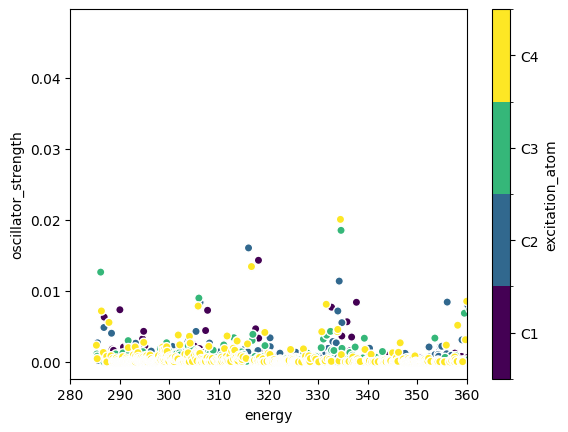

In [46]:
# from the xarray datatree construct the NEXAFS spectra
import matplotlib.pyplot as plt

transitions = calc["TP/transitions"].ds
transitions.plot.scatter(
    x="energy",
    y="oscillator_strength",
    hue="excitation_atom",
)
plt.xlim(280, 360)
plt.show()

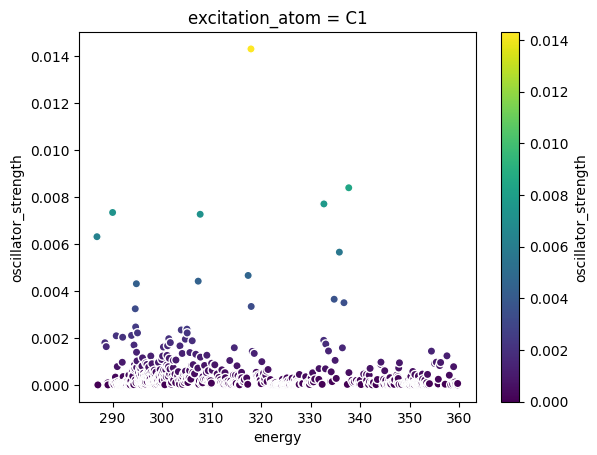

In [99]:
test_calcs = (
    calc["TP/transitions"].ds.sel({"excitation_atom": "C1"}).dropna(dim="energy")
)
# select energyes <= 360
test_calcs = test_calcs.sel({"energy": slice(None, 360)})
test_calcs.plot.scatter(
    x="energy",
    y="oscillator_strength",
    hue="oscillator_strength",
)

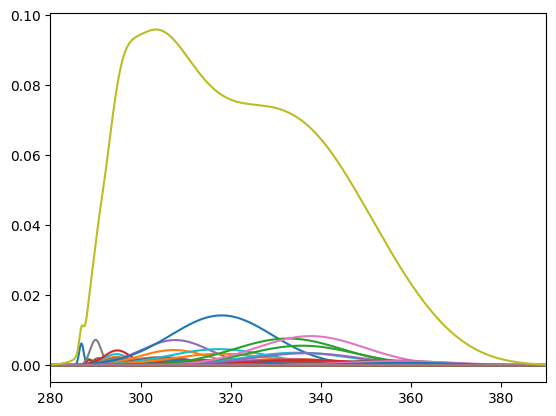

In [105]:
def broadening(E, ewid1, width1, ewid2, width2):
    """
    Calculate the broadening of the spectrum.

    Parameters
    ----------
    E : float
        The energy value.
    ewi1 : float
        The energy width for the first Gaussian.
    width1 : float
        The width of the first Gaussian.
    ewi2 : float
        The energy width for the second Gaussian.
    width2 : float
        The width of the second Gaussian.

    Returns
    -------
    float
        The broadening value.
    """
    if ewid1 > E:
        return width1
    elif ewid2 < E:
        return width2
    else:
        return width1 + (width2 - width1) * (E - ewid1) / (ewid2 - ewid1)


def gaussian(x, mu, sigma, amplitude):
    """
    Calculate the Gaussian function.

    Parameters
    ----------
    x : float
        The x value.
    mu : float
        The mean of the Gaussian.
    sigma : float
        The standard deviation of the Gaussian.
    amplitude : float
        The amplitude of the Gaussian.

    Returns
    -------
    float
        The Gaussian value.
    """
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def plot_total_spectra(
    energies: np.ndarray,
    oscillator_strengths: np.ndarray,
    ewid1: float,
    width1: float,
    ewid2: float,
    width2: float,
):
    """
    Plot the total spectra.

    Parameters
    ----------
    energies : np.ndarray
        The energy values.
    oscillator_strengths : np.ndarray
        The oscillator strengths.
    ewid1 : float
        The energy width for the first Gaussian.
    width1 : float
        The width of the first Gaussian.
    ewid2 : float
        The energy width for the second Gaussian.
    width2 : float
        The width of the second Gaussian.
    """
    # Calculate the broadening for each energy value
    widths = np.array([broadening(E, ewid1, width1, ewid2, width2) for E in energies])
    energy_grid = np.linspace(250, 390, num=1000)  # Create a grid for the energies

    # Calculate the Gaussian values for each energy value
    gaussians = np.array(
        [
            gaussian(energy_grid, E, widths[i], oscillator_strengths[i])
            for i, E in enumerate(energies)
        ]
    )

    # Sum the Gaussian values to get the total spectrum
    total_spectrum = np.sum(gaussians, axis=0)
    for i, E in enumerate(energies):
        plt.plot(energy_grid, gaussians[i], label=f"Gaussian {i + 1}")

    # Plotting
    plt.plot(energy_grid, total_spectrum)
    plt.xlim(280, 390)


plot_total_spectra(
    test_calcs["energy"].to_numpy(),
    test_calcs["oscillator_strength"].to_numpy(),
    288,
    0.5,
    320,
    12,
)

38

/tmp/ipykernel_1775189/3553428077.py:118: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(ovp))


[]

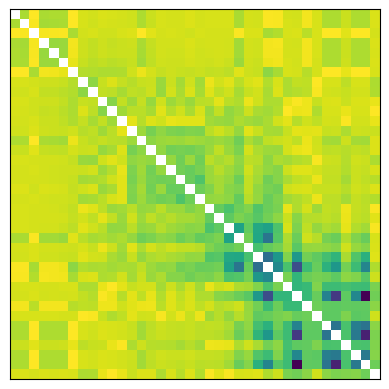

In [155]:
from calendar import c
from scipy.integrate import quad


def _overlap_area(mu1, sigma1, amp1, mu2, sigma2, amp2):
    def integrand(x):
        return np.minimum(
            gaussian(x, mu1, sigma1, amp1),
            gaussian(x, mu2, sigma2, amp2),
        )

    # Integrate over a range wide enough to cover both peaks
    lower_bound = min(mu1 - 3 * sigma1, mu2 - 3 * sigma2)
    upper_bound = max(mu1 + 3 * sigma1, mu2 + 3 * sigma2)
    overlap, _ = quad(integrand, lower_bound, upper_bound)
    return overlap


def tdm_overlap(tdm_1, tdm_2):
    """
    Calculate the overlap between two transition dipole moments.

    Parameters
    ----------
    tdm_1 : np.ndarray
        The first transition dipole moment.
    tdm_2 : np.ndarray
        The second transition dipole moment.

    Returns
    -------
    float
        The overlap value.
    """
    return np.dot(tdm_1, tdm_2) / (np.linalg.norm(tdm_1) * np.linalg.norm(tdm_2))


# thresholding - Keep transitions where oscillator_strength > 0
# Use .where() to filter based on data variable values, not .sel() which works on
# coordinates/dimensions

test_calcs["oss_norm"] = (
    test_calcs["oscillator_strength"] / test_calcs["oscillator_strength"].max()
)
test_calcs = test_calcs.where(test_calcs["oss_norm"] > 0.001, drop=True)


def calculate_overlap(transitions: xr.Dataset):
    """
    Calculate the distance matrix based on the overlap area of Gaussian peaks
    representing transitions.

    Parameters
    ----------
    transitions : xr.Dataset
        An xarray Dataset containing transition data with 'energy' and 'oss_norm'
        variables, and potentially others needed for broadening calculation.
        Assumes 'energy' is a coordinate and data variables are aligned with it.

    Returns
    -------
    np.ndarray
        A square matrix representing the distance (100 - overlap area) between
        each pair of transitions.
    """  # noqa: D205
    energies = transitions["energy"].to_numpy()
    amplitudes = transitions["oss_norm"].to_numpy()
    n = energies.shape[0]
    overlap_matrix = np.zeros((n, n))

    # Pre-calculate widths for all transitions
    widths = np.array([broadening(E, 288, 0.5, 320, 12) for E in energies])

    for i in range(n):
        tdm_i = np.array(
            [
                transitions["oslx"].to_numpy()[i],
                transitions["osly"].to_numpy()[i],
                transitions["oslz"].to_numpy()[i],
            ]
        )
        for j in range(
            i, n
        ):  # Start j from i to calculate only upper triangle + diagonal
            # Calculate overlap area using pre-calculated widths
            tdm_j = np.array(
                [
                    transitions["oslx"].to_numpy()[j],
                    transitions["osly"].to_numpy()[j],
                    transitions["oslz"].to_numpy()[j],
                ]
            )
            overlap = _overlap_area(
                energies[i],
                widths[i],
                amplitudes[i],
                energies[j],
                widths[j],
                amplitudes[j],
            ) + tdm_overlap(
                tdm_i,
                tdm_j,
            )
            overlap_matrix[i, j] = overlap

            if i != j:
                overlap_matrix[j, i] = overlap  # Symmetric matrix

    distance_matrix = 100 - overlap_matrix
    np.fill_diagonal(distance_matrix, 0)

    return distance_matrix


display(test_calcs["energy"].shape[0])
ovp = calculate_overlap(test_calcs)
fig, ax = plt.subplots()
ax.imshow(np.log(ovp))
ax.set_xticks([])
ax.set_yticks([])

Running make_step_python example...
IPs: [291.96863, 290.45758, 290.19235, 290.1377]
Points per spectrum: 300
Number of spectra: 4
Generated concatenated steps array with shape: (1200,)


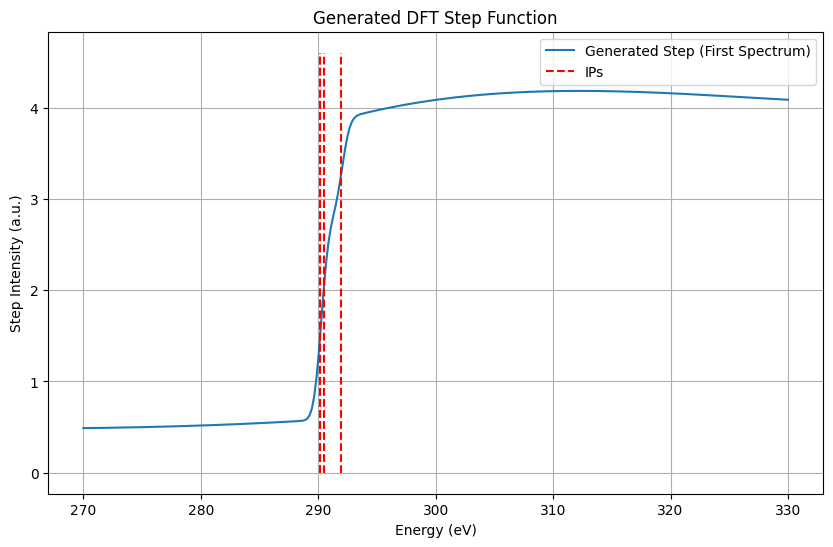

In [ ]:
import warnings

import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.special import erf


# Placeholder functions for finding Bare Atom Mass Absorption data
# These need to be implemented based on how/where your BAMA data is stored.
def find_ba_energy_python():
    """
    Placeholder function to load Bare Atom Mass Absorption energy data.

    Returns:
                    np.ndarray: Array of energies for BAMA data.
    """
    # Example: Load from a file or database
    # Replace with your actual data loading mechanism
    print("Warning: Using placeholder BAMA energy data.")
    # Dummy data for demonstration
    return np.linspace(200, 400, 500)


def find_bama_python(mol):
    """
    Placeholder function to load Bare Atom Mass Absorption intensity data
    for a given molecule.

    Args:
                    mol (str): Molecule identifier.

    Returns:
                    np.ndarray: Array of BAMA intensities corresponding to the energies
                                                                    from find_ba_energy_python().
    """
    # Example: Load from a file or database based on 'mol'
    # Replace with your actual data loading mechanism
    print(f"Warning: Using placeholder BAMA intensity data for molecule '{mol}'.")
    # Dummy data for demonstration - a simple step-like function
    energies = find_ba_energy_python()
    mu = np.ones_like(energies) * 0.1
    mu[energies > 285] = 1.0
    return mu + np.random.rand(len(energies)) * 0.05  # Add some noise


def gstep_python(x, x0, width):
    """
    Gaussian step function.

    Args:
                    x (np.ndarray or float): Input energy/variable.
                    x0 (float): Step center position.
                    width (float): Step width (related to standard deviation).

    Returns:
                    np.ndarray or float: Value of the Gaussian step function.
    """
    # c = 2 * sqrt(2*ln(2)) for FWHM, Igor's Gstep uses width/2 for 1/e points?
    # Matching Igor's Gstep definition which seems closer to erf((x-x0)/(width/sqrt(2)))
    # However, the Igor code uses c=2*sqrt(2), which relates width to std dev (sigma)
    # as width = sigma * 2 * sqrt(2). Let's stick to the Igor code's formula.
    # If width is intended as FWHM, c should be 2*sqrt(2*ln(2)) ~ 2.355
    # If width is std dev * 2, c should be 2.
    # The Igor code explicitly defines c = 2*sqrt(2) ~ 2.828
    c = 2 * np.sqrt(2)
    # Add a small epsilon to width to avoid division by zero if width is zero
    epsilon = 1e-9
    return 0.5 + 0.5 * erf((x - x0) / (width / c + epsilon))


def fit_poly3_python(y, x, start_x, end_x):
    """
    Fits a 3rd order polynomial to a portion of the data.

    Args:
                    y (np.ndarray): Dependent variable data.
                    x (np.ndarray): Independent variable data.
                    start_x (float): Start value of x for fitting range.
                    end_x (float): End value of x for fitting range.

    Returns:
                    np.poly1d: A polynomial object representing the fit.
    """
    # Find indices corresponding to the fitting range
    idx = np.where((x >= start_x) & (x <= end_x))[0]
    if len(idx) < 4:  # Need at least 4 points for a 3rd order polyfit
        warnings.warn(
            f"Warning: Not enough points ({len(idx)}) in range [{start_x}, {end_x}] for 3rd order polynomial fit. Returning linear fit or zeros."
        )
        if len(idx) >= 2:
            coeffs = np.polyfit(x[idx], y[idx], 1)  # Fit linear if possible
            # Pad with zeros for higher order terms
            coeffs = np.concatenate(([0.0, 0.0], coeffs))
        else:
            coeffs = np.zeros(4)  # Return zero polynomial
    else:
        coeffs = np.polyfit(x[idx], y[idx], 3)

    return np.poly1d(coeffs)


def make_step_python(
    ip_corr,
    pnts_per_spec,
    step_wid1,
    step_wid2,
    step_e1,
    step_e2,
    mol,
    dummy_energy,
    n_spec,
):
    """
    Generate concatenated step edge functions based on DFT Ionization Potentials (IPs).

    Args:
    -----
        ip_corr (np.ndarray): 1D array of corrected ionization potentials.
        pnts_per_spec (int): Number of data points per individual spectrum.
        step_wid1 (float): Step width corresponding to step_e1 (or min IP).
        step_wid2 (float): Step width corresponding to step_e2 (or max IP).
        step_e1 (float): Energy for step_wid1 (Note: Igor code uses min IP).
        step_e2 (float): Energy for step_wid2 (Note: Igor code uses max IP).
        mol (str): Molecule identifier (for BAMA lookup).
        dummy_energy (np.ndarray): 1D array representing the energy scale for one spectrum.
        n_spec (int): Number of spectra to concatenate.

    Returns
    -------
    np.ndarray: 1D array containing the concatenated step functions for all spectra.
        Returns None if dummy_energy is invalid.
    """
    if dummy_energy is None or len(dummy_energy) != pnts_per_spec:
        print("Error: dummy_energy must be a NumPy array with length pnts_per_spec.")
        return None

    # Define energy ranges (consistent with Igor code)
    start_pre = 240.0
    end_pre = 284.1
    start_post = 284.3
    end_post = 360.0

    # --- Bare Atom Absorption (BAMA) Processing ---
    mu_energy = find_ba_energy_python()
    mu = find_bama_python(mol)

    # Fit polynomial to pre-edge and post-edge of BAMA
    pre_edge_poly = fit_poly3_python(mu, mu_energy, start_pre, end_pre)
    post_edge_poly = fit_poly3_python(mu, mu_energy, start_post, end_post)

    # Calculate intensity values at the stitch points using the polynomials
    stitch_low = pre_edge_poly(end_pre)
    stitch_high = post_edge_poly(start_post)
    # --- End BAMA Processing ---

    # --- Step Generation ---
    n_atoms = len(ip_corr)
    if n_atoms == 0:
        print("Warning: ip_corr is empty. Returning zeros.")
        return np.zeros(pnts_per_spec * n_spec)

    # Find min/max IPs and their values
    ip_min_val = np.min(ip_corr)
    ip_max_val = np.max(ip_corr)
    ip_min_loc_val = ip_min_val  # Use value directly
    ip_max_loc_val = ip_max_val  # Use value directly

    # Find indices in the experimental energy scale corresponding to IP range
    # Use searchsorted to find insertion points, which correspond to indices
    dft_pre_en2_idx = np.searchsorted(dummy_energy, ip_min_loc_val, side="left")
    dft_pos_en2_idx = np.searchsorted(dummy_energy, ip_max_loc_val, side="left")

    # Ensure indices are within bounds
    dft_pre_en2_idx = max(0, dft_pre_en2_idx)
    dft_pos_en2_idx = min(pnts_per_spec - 1, dft_pos_en2_idx)
    if (
        dft_pre_en2_idx > dft_pos_en2_idx
    ):  # Handle case where IP range is inverted or very narrow
        dft_pos_en2_idx = dft_pre_en2_idx

    step_sum = np.zeros(pnts_per_spec)
    step_decay = 0.0  # As defined in Igor code

    ip_range = ip_max_loc_val - ip_min_loc_val
    # Add epsilon to avoid division by zero if all IPs are the same
    epsilon = 1e-9
    ip_range = ip_range if ip_range > epsilon else epsilon

    for i in range(n_atoms):
        e0 = ip_corr[i]

        # Calculate energy-dependent step width using linear interpolation
        # Based on the Igor code's formula using min/max IPs
        step_wid = (step_wid1) + ((step_wid2 - step_wid1) / ip_range) * (
            e0 - ip_min_loc_val
        )

        w = np.zeros(pnts_per_spec)

        # Pre-edge region: Evaluate pre-edge polynomial
        pre_indices = np.arange(0, dft_pre_en2_idx)
        if len(pre_indices) > 0:
            w[pre_indices] = pre_edge_poly(dummy_energy[pre_indices])

        # Step region: Use Gaussian step function
        step_indices = np.arange(dft_pre_en2_idx, dft_pos_en2_idx + 1)
        if len(step_indices) > 0:
            gstep_vals = gstep_python(dummy_energy[step_indices], e0, step_wid)
            # Igor code applies exp decay, but stepDecay is 0
            decay_factor = np.exp(
                -step_decay * (dummy_energy[step_indices] - e0 - step_wid)
            )
            w[step_indices] = (
                (stitch_high - stitch_low) * gstep_vals
            ) * decay_factor + stitch_low

        # Post-edge region: Evaluate post-edge polynomial
        post_indices = np.arange(dft_pos_en2_idx + 1, pnts_per_spec)
        if len(post_indices) > 0:
            w[post_indices] = post_edge_poly(dummy_energy[post_indices])

        # Smooth the individual step (using Gaussian filter as approximation for Igor's Smooth 10)
        # Sigma choice is heuristic to approximate 'Smooth 10'. Adjust if needed.
        sigma_smooth = 2.5  # Adjust this sigma based on desired smoothing level
        w_smoothed = gaussian_filter1d(
            w, sigma=sigma_smooth, mode="nearest"
        )  # 'nearest' boundary condition

        step_sum += w_smoothed
    # --- End Step Generation ---

    # Concatenate the summed step function for the number of spectra
    all_dft_steps = np.tile(step_sum, n_spec)

    return all_dft_steps


# Example Usage:
if __name__ == "__main__":
    # --- Dummy Input Data ---
    num_ip = 5
    ip_corr_data = [291.96863, 290.45758, 290.19235, 290.1377]
    points_per_spectrum = 300
    energy_min = 270
    energy_max = 330
    dummy_energy_data = np.linspace(energy_min, energy_max, points_per_spectrum)
    num_spectra = 4

    step_width1 = 0.2
    step_width2 = 0.8
    # step_e1/e2 are not directly used in the loop in the Igor code provided,
    # it uses min/max of ip_corr instead. We'll pass dummy values.
    step_energy1 = 285.0
    step_energy2 = 295.0
    molecule_name = "dummy_mol"
    # --- End Dummy Input Data ---

    print("Running make_step_python example...")
    print(f"IPs: {ip_corr_data}")
    print(f"Points per spectrum: {points_per_spectrum}")
    print(f"Number of spectra: {num_spectra}")

    concatenated_steps = make_step_python(
        ip_corr_data,
        points_per_spectrum,
        step_width1,
        step_width2,
        step_energy1,
        step_energy2,
        molecule_name,
        dummy_energy_data,
        num_spectra,
    )

    if concatenated_steps is not None:
        print(
            f"Generated concatenated steps array with shape: {concatenated_steps.shape}"
        )

        # Optional: Plotting for verification
        try:
            import matplotlib.pyplot as plt

            full_energy_axis = np.tile(
                dummy_energy_data, num_spectra
            )  # Simple tiling for plotting
            plt.figure(figsize=(10, 6))
            # Plot the first generated step
            plt.plot(
                dummy_energy_data,
                concatenated_steps[:points_per_spectrum],
                label="Generated Step (First Spectrum)",
            )

            # Overlay IPs
            step_max_val = np.max(concatenated_steps[:points_per_spectrum])
            plt.vlines(
                ip_corr_data,
                0,
                step_max_val * 1.1,
                color="red",
                linestyle="--",
                label="IPs",
            )

            plt.xlabel("Energy (eV)")
            plt.ylabel("Step Intensity (a.u.)")
            plt.title("Generated DFT Step Function")
            plt.legend()
            plt.grid(True)
            plt.show()
        except ImportError:
            print("Matplotlib not found. Skipping plot.")
    else:
        print("Failed to generate steps.")
